# Basic VQE

We will showcase some basic circuit constructions within tequila via the UpCCGSD circuit class.  
Note that you can create the circuits also via `mol.make_ansatz(name="2-UpCCGSD")` and similar for the other names.  
We will use canonical Hartree-Fock (HF) orbitals in a closed-shell formulation, the terms occupied refer to those orbitals occupied in the HF reference, while virtual refers to the rest. The HF reference can be prepared via a simple circuit obtained from `mol.prepare_reference`.

Dependencies for the code in this tutorial
```
pip install tequila-basic
pip install pyscf
pip install qulacs
```

Essential imports in the next cell:

In [1]:
import tequila as tq
QCircuit = tq.QCircuit

The following figure illustrates the different circuits using a high-level representation:
- each line is a spatial orbital
- circles indicate single excitations (one operation includes spin-up and spin-down excitations)
- squared indicate paired double excitations (two spin-paired electrons from one spatial orbital into the other)

The color code indicates what is created by the individual code blocks below.

![](circuit.png){width=400}

The UpCCD circuit includes all paired double excitations from occupied to virtual orbitals

In [2]:
def UpCCD(m):
    U = QCircuit()
    # occupied HF reference orbitals 
    for i in reversed(range(0, m.n_electrons//2)):
        # unoccupied HF reference orbitals
        for a in range(m.n_electrons//2, m.n_orbitals):
            U += m.UC(i,a)

    return U

The next stage is the inclusion of the missing paired double excitations

In [3]:
def UpCCGD(m):
    U = UpCCD(m)
    for i in range(0,m.n_electrons//2):
        for j in range(i+1,m.n_electrons//2):
            U += m.UC(i,j)
    for a in range(m.n_electrons//2, m.n_orbitals):
        for b in range(a+1, m.n_orbitals):
            U += m.UC(a,b)
            
    return U

Finally we add all possible single excitations

In [4]:
def UpCCGSD(m):
    U = UpCCGD(m)
    for k in range(0, m.n_orbitals):
        for l in range(k+1, m.n_orbitals):
            U += m.UR(k,l)
    return U

As an example we compute the VQE energies of a $H_4$ molecule with different bond distances. 
We illustrate UpCCD and UpCCGSD and use either random or fixed initial values. 
Initial values fixed to zero essentially start from the HF reference. You will see that this is not sufficient to find the best paramters for the UpCCGSD -- however, random initialization is also not the practiable solution, as you usually need a few tries.  

Our example looks like this  
  
![](h4_mol.png){width=300}  
  
with a variable $R$ and fixed $d=0.75$ Angstroms. 

In [5]:
#| code-fold: false
#| output: false
d = 0.75
R = 0.5
data = {"exact":{}}
for _ in range(15):
    R += 0.2
    geom = "H 0.0 0.0 0.0\nH 0.0 0.0 0.75\nH 0.0 0.0 {}\nH 0.0 0.0 {}".format(d+R, d+R+d)
    mol = tq.Molecule(geometry=geom, basis_set="sto-3g")
    U0 = mol.prepare_reference()
    H = mol.make_hamiltonian()
    
    data["exact"][R]=mol.compute_energy("fci")
    for circDesign in [UpCCD, UpCCGSD]:
        name = str(circDesign.__name__)
        U = U0 + circDesign(mol)
        E = tq.ExpectationValue(U=U, H=H)
        for iv in ["zero", "random"]:
            xname = name+"("+str(iv)+")"
            if xname not in data: data[xname]={}
            result = tq.minimize(E, silent=True, initial_values=iv)
            data[xname][R]=result.energy


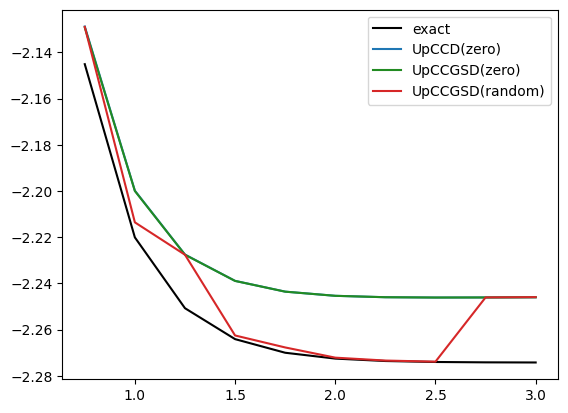

In [13]:
#| code-fold: true
from matplotlib import pyplot as plt

color = {"exact":"black", "UpCCD(zero)":"tab:blue", "UpCCGSD(zero)":"forestgreen", "UpCCGSD(random)":"tab:red"}
for name,d in data.items():
    x = list(d.keys())
    y = list(d.values())
    if name in color:
        plt.plot(x,y,label=name, color=color[name])
plt.legend()
plt.show()